### 3-1. 카메라 스티커앱 만들기 첫걸음 

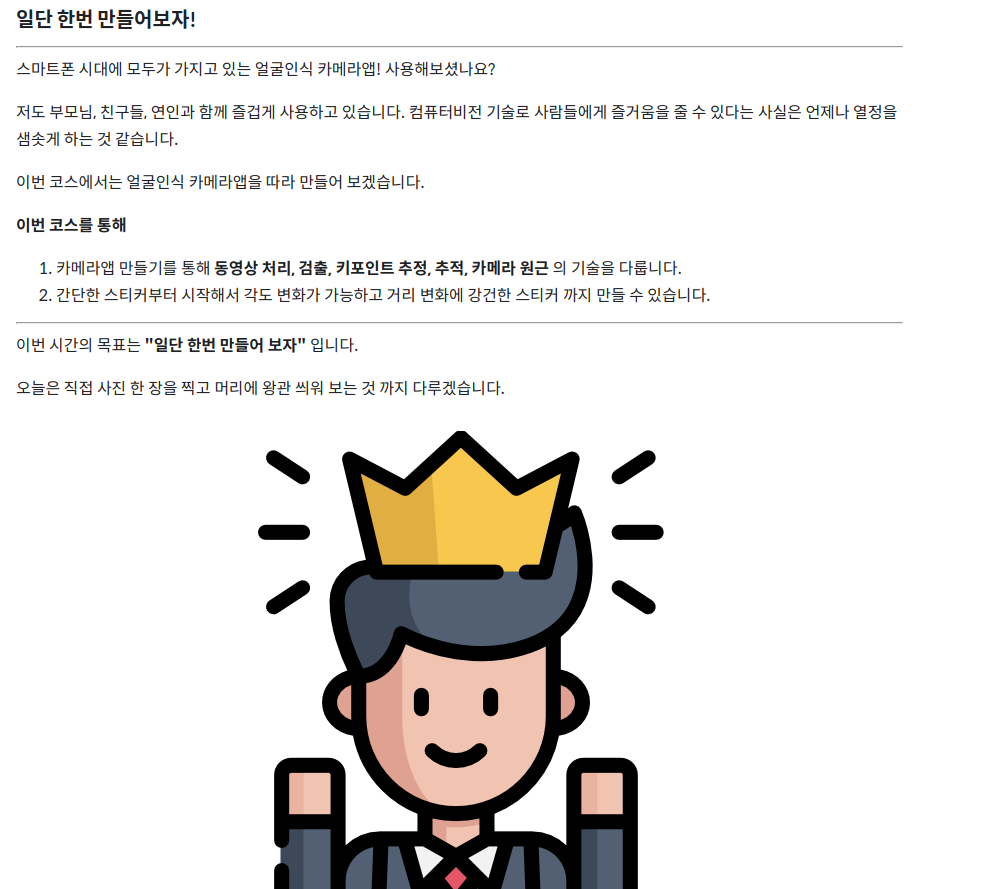

## 목표 
1. 얼굴인식 카메라의 흐름을 이해  
2. dlib 라이브러리 사용  
3. 이미지 배열의 인덱싱 예외 처리 


## 3-2. 어떻게 만들까? 사진 준비하기 
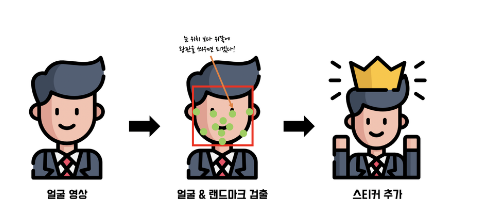

1. 얼굴이 포함된 사진을 준비하기!
2. 얼굴영역 바운딩 박스 그리기!
3. 얼굴영역 face landmark 찾기! 
3. 찾아진 영역에서 위치 찾아서 스티커 붙이기!

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#이미지 처리는 opencv 
#이미지 출력은 matplotlib
#opencv는 bgr로 출력되기 때문에 `cv2.cvtColor('이미지이름'cv2.COLOR_BGR2RGB`)로 수정해야함.

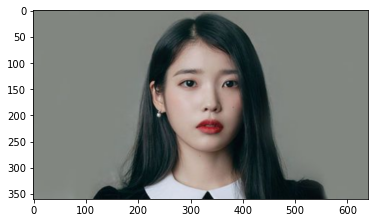

In [3]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/iu1.jpg'
img_bgr = cv2.imread(my_image_path) #opencv로 이미지 읽어오기 
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)#
img_rgb = cv2.resize(img_rgb,(640,360)) #opencv로 이미지 사이즈 변경

img_show = img_rgb.copy() #출력용으로 이미지 별도 보관
plt.imshow(img_show)
plt.show()

## 3-3. 얼굴 검출 face detection

1. 얼굴의 위치를 찾는다. 
>+ 이미지에서는 gradient를 feature로 사용한다. 
>+ HOG를 사용하여 얼굴을 인식한다. (이때 색상은 필요없기 때문에 gragscale을 준다)
>+ 이미지가 어두워지는 방향으로 나타내는 화살표를 그린다. 이것을 gradients라고 한다. 
>+ 단일 픽셀에 대한 gradient를 확인하는 것보다 이미지의 기본 패턴을 인식하도록 밝음/어두음의 흐름만 봅니다. 16*16 크기로 이미지르 자르고 가장 강한 화살표 방향으로 바꿈(밝음 > 어둠)
>+ HOG는 다양한 이미지로 부터 강한 화살표 방향을 갖고 있는게 있는데 이걸 가지고 내 이미지에서 유사한 부분을 찾아냅니다. 

2. 얼굴의 위치 교정과 투영
>+ face landmark estimation은 이미지의 각도가 달라도 인식이 가능하게 합니다. 
>+ 모든 얼굴에 존재하는 68개의 특정포인트(landmarks)를 찾아 냅니다. 
>+ 특정포인트를 찾았으니 회전과 크기를 조절해서 비틀어서 affine transformations(변환방법)을 합니다. 

3. 얼굴 인코딩 
>+ landmark를 찾아낸 사람과 비슷하게 보이는 사람을 찾는다면 시간이 너무 오래 걸리는 문제점이 발생합니다. 
>+ 각 얼굴에서 몇 가지 가본 측정값을 추출합니다. 
>+ 딥러닝이 알아서 어느 부분이 측정에 있어 중요한지 파악하도록 하기!
>+ 중요도는 128개의 측정값을 **embedding**한다. 이거는  openface에서 제공하고 있습니다. 
>+ 내가 할 일은 사전 훈련된 신경망을 사용해서 우리의 얼굴 이미지로부터 각 얼굴에 대한 128개의 측정값을 얻는 것입니다. 

4. 인코딩에서 사람의 이름찾기 


In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()

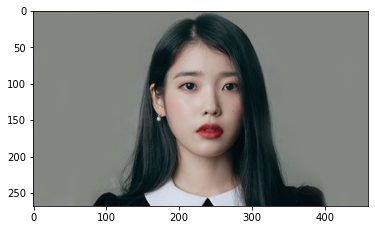

In [5]:
#detector를 사용해 bbox를 만들기! 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)#그냥 있는 이미지를 사용하려고 했더니 푸르딩딩합니다. 그래서 다시 이미지를 저장해주었습니다. 
plt.imshow(img_rgb)
dlib_rects = detector_hog(img_rgb,2) #두번째 옵션은 피라미드의 수입니다.

In [6]:
#upsampling방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다. 
#이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기에 정확한 검출가능! 
#이미지 피라미드는 동일한 이미지를 서로 다른 사이즈로 쌓는다. 
#가장 아래에 있는게 해상도가 가장 크고 점점 줄여가면서 쌓는다. 

In [7]:
print(dlib_rects)

rectangles[[(173, 55) (307, 189)]]


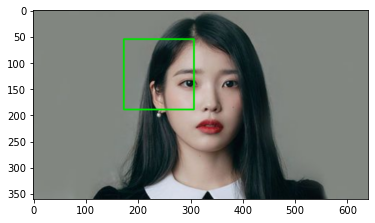

In [8]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    img_show_rgb = cv2.rectangle(img_show,(l,t),(r,b),(0,225,0),2,lineType=cv2.LINE_AA)

# img_show_rgb  = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
#왜 이미지 색변경을 했는데 안될까..음...일단 넘어가자.

plt.imshow(img_show_rgb)

## 3-4. 얼굴 랜드마크 

bbox로 잘라낸 얼굴을 이용하여 face landmark localization을 합니다. 

**object keypoint estimation 알고리즘** 
+ 객체 내부의 점을 찾는 기술 
>+ top-down: bbox를 찾고 bbox 내부의 keypoint를 예측
>+ bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point관계를 이용해서 군집화 해서 box생성

### Dlib landmark localization 

+ 잘라진 얼굴 이미지에서 68개의 이목구비 위치를 찾는다. 


In [9]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [10]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show,dlib_rect)
    list_points = list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

68


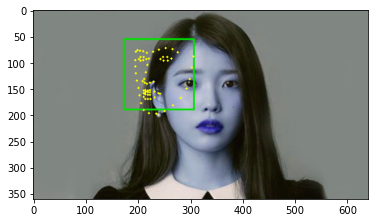

In [11]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 회고

사람이 많아서 BTS가 될까 했는데 
1) 피라미드 갯수를 몇개나 쌓을 것인가에서 처음에 1로 했을 때는 얼굴을 3명만 인식했다. 
2) 5로 하니깐 4명만 인식했다. 물론 시간이 좀 더 걸렸다. 그래도 얼굴을 다 못 찾았다. 
3) 10으로 늘리니깐 커널이 죽었다. 최적의 피라미드를 찾아보고자 했다. 
4) 피라미드를 8로 만들었다. 메모리 에러가 나왔다. 
5) 그냥 6으로 해봤다. bbox가 3명으로 줄었다. 그냥 5로 하자! 얼굴이 너무 작아서 못 찾거나 음..얼굴이 기우뚱해서 못 찾는 것으로 보인다. 

6) 이미지를 새롭게 불러와서 진행을 하니깐 bbox를 더 잘 친다. 왜 그럴까?
7) 이미지를 새롭게 불러온 거에서 피라미드를 6으로 하니깐 커널이 자꾸 죽었다. 

결국 BTS는 bbox를 다 못 쳐서 blackpink로 도전해보았다. 
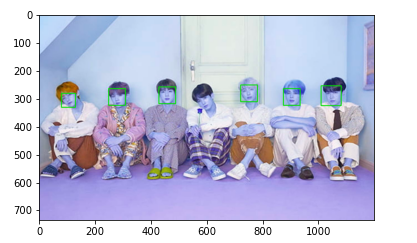

블랙핑크는 bbox만 성공! > 68개의 점을 찍지 못한다.  
피라미드를 3개만 쌓았더니.. 한 얼굴에 bbox를 2개씩 씌우고 1명의 얼굴은 인식을 못함. 
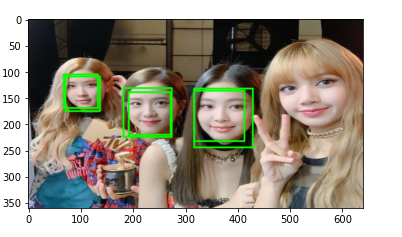

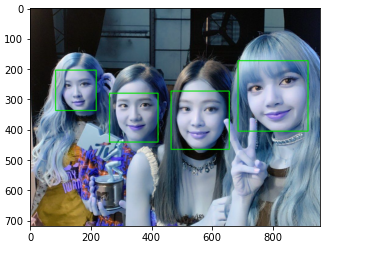

욕심을 버리고 1명으로 도전해 보았다. 

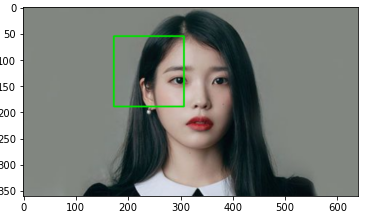
시작은 얼굴이 어떤건지 모르는 것처럼 보였다. 

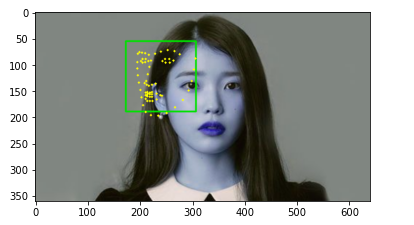
아이유가 사진을 찍을 때 심령이 있었던 것으로 추정된다. 
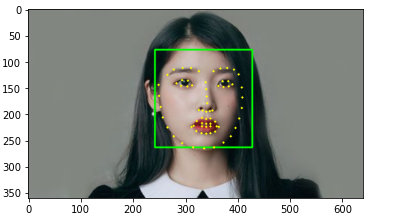
그래도 어찌어찌 실수를 거듭하고 문제를 해결했다. 